In [214]:
import pandas
import numpy as np

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

## Подход 1: градиентный бустинг "в лоб"

### 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [218]:
features = pandas.read_csv('./features.csv', index_col='match_id')

In [219]:
features = features.drop(['duration',
                         'tower_status_radiant',
                         'tower_status_dire',
                         'barracks_status_radiant',
                         'barracks_status_dire'], axis=1)

In [220]:
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,1
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,0


### 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [221]:
print('{} столбцов, которые имеют пропущенные значения:'.format(sum(features.count() < len(features))))
for col in features.columns[features.count() < len(features)]:
    print('\t', col)

12 столбцов, которые имеют пропущенные значения:
	 first_blood_time
	 first_blood_team
	 first_blood_player1
	 first_blood_player2
	 radiant_bottle_time
	 radiant_courier_time
	 radiant_flying_courier_time
	 radiant_first_ward_time
	 dire_bottle_time
	 dire_courier_time
	 dire_flying_courier_time
	 dire_first_ward_time


+ Столбец <i>first_blood_time</i> будет иметь пропущенное значение, если "первая кровь" не произошла в первие 5 минут игры
+ По той же причине пропуски имею и столбцы: <i>first_blood_team, first_blood_player1, first_blood_player2</i>

+ Аналогично, если время первого приобретения произошло не в первые 5 минут, то <i>radiant_bottle_time</i> будет иметь пропущенное значение
+ и тд

### 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [222]:
features = features.fillna(0)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 103 entries, start_time to radiant_win
dtypes: float64(12), int64(91)
memory usage: 77.1 MB


### 4. Какой столбец содержит целевую переменную? Запишите его название.

In [223]:
y = features['radiant_win']
features = features.drop(['radiant_win'], axis=1)

+ Столбец, который содержит целевую переменную: <b><i>radiant_win</i></b>

### 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [224]:
cv = KFold(n_splits=5, shuffle=True)

In [225]:
import time
import datetime

In [226]:
scores = []
for n in np.arange(10, 31, 10):
    start_time = datetime.datetime.now()
    gbc = GradientBoostingClassifier(n_estimators=n)
    scores.append(cross_val_score(gbc, features, y, cv=cv, scoring='roc_auc').mean())
    print ('Time elapsed (n_estimators = {}):'.format(n), datetime.datetime.now() - start_time)

Time elapsed (n_estimators = 10): 0:00:28.063298
Time elapsed (n_estimators = 20): 0:00:51.551985
Time elapsed (n_estimators = 30): 0:01:21.889227


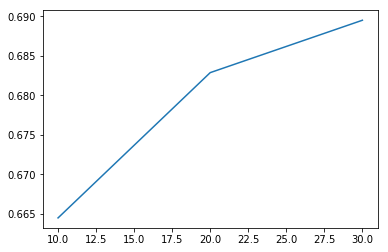

In [227]:
plt.plot(np.arange(10, 31, 10), scores)

+ Классификатор с n_estimators=30 настраиветься за 77секунд 
+ При дальнейшем увеличении качество продолжит расти, но в итоге выйдет на асимптотический уровень
+ Нет смысла увеличивать n_estimators, поскольку прирост в точности будет достаточно малым, но время работы алгоритма возрастет значительно
+ Чтобы ускорить обучение алгоритма при увеличении количества деревьев можно настроить гиперпараметры (max_depth) или же использовать для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество

In [228]:
print('Значение метрики AUC-ROC при n_estimators = {}: {}'.format(30, scores[-1]))

Значение метрики AUC-ROC при n_estimators = 30: 0.6895046585263934


## Подход 2: логистическая регрессия

### 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [229]:
scaler = StandardScaler()

In [230]:
X = scaler.fit_transform(features)

C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [231]:
cv = KFold(n_splits=5, shuffle=True)

In [232]:
scores = []
best_c = None
best_score = 0
for c in np.linspace(0.01, 5, 20):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=c)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc').mean()
    if score > best_score:
        best_c = c
        best_score = score
    scores.append(score)
    print ('Time elapsed (C = {}):'.format(c), datetime.datetime.now() - start_time)

C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.01): 0:00:13.689865


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.27263157894736845): 0:00:15.611564


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.5352631578947369): 0:00:18.523111


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.7978947368421053): 0:00:14.717704


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.0605263157894738): 0:00:18.094727


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.3231578947368423): 0:00:19.688380


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.5857894736842106): 0:00:20.877743


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.848421052631579): 0:00:18.108760


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.1110526315789473): 0:00:18.114106


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.373684210526316): 0:00:17.392071


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.6363157894736844): 0:00:21.495647


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.8989473684210525): 0:00:17.369290


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.161578947368421): 0:00:16.088490


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.4242105263157896): 0:00:15.991506


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.6868421052631577): 0:00:17.745233


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.9494736842105262): 0:00:15.525577


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.212105263157895): 0:00:15.683553


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.474736842105263): 0:00:14.989664


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.737368421052632): 0:00:15.629561


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 5.0): 0:00:15.572574


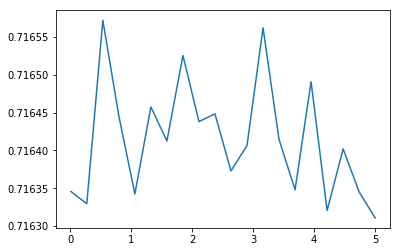

In [236]:
plt.plot(np.linspace(0.01, 5, 20), scores)

In [237]:
print('Лучший параметр регуляризации C = {}'.format(best_c))
print('Наилучшее качество score = {}'.format(best_score))

Лучший параметр регуляризации C = 0.5352631578947369
Наилучшее качество score = 0.716571829627078


+ Качество, полученное при LR больше, чем при GradientBoostingClassifier
+ Так получилось, потому что LR лучше работает с разреженными данными
+ LR работает быстрее, чем GradientBoostingClassifier

### 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [238]:
X = features.drop(['lobby_type', 'r1_hero',
                   'r2_hero', 'r3_hero',
                   'r4_hero', 'r5_hero',
                  'd1_hero', 'd2_hero',
                  'd3_hero', 'd4_hero',
                  'd5_hero'], axis=1)

In [239]:
scaler = StandardScaler()

In [240]:
X = scaler.fit_transform(X)

C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [241]:
cv = KFold(n_splits=5, shuffle=True)

In [242]:
scores = []
best_c = None
best_score = 0
for c in np.linspace(0.01, 5, 20):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=c)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc').mean()
    if score > best_score:
        best_c = c
        best_score = score
    scores.append(score)
    print ('Time elapsed (C = {}):'.format(c), datetime.datetime.now() - start_time)

C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.01): 0:00:13.125952


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.27263157894736845): 0:00:13.188943


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.5352631578947369): 0:00:13.372916


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.7978947368421053): 0:00:13.426904


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.0605263157894738): 0:00:13.383911


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.3231578947368423): 0:00:13.794848


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.5857894736842106): 0:00:13.099956


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.848421052631579): 0:00:13.210943


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.1110526315789473): 0:00:15.947510


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.373684210526316): 0:00:15.256621


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.6363157894736844): 0:00:17.110331


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.8989473684210525): 0:00:14.743700


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.161578947368421): 0:00:16.367447


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.4242105263157896): 0:00:13.869837


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.6868421052631577): 0:00:17.064337


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.9494736842105262): 0:00:15.936514


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.212105263157895): 0:00:14.594726


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.474736842105263): 0:00:15.269609


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.737368421052632): 0:00:12.740013


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 5.0): 0:00:12.480053


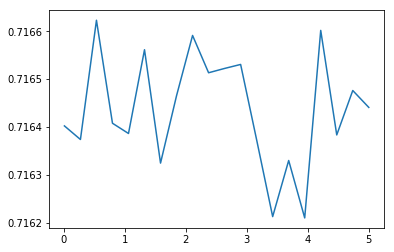

In [243]:
plt.plot(np.linspace(0.01, 5, 20), scores)

In [244]:
print('Лучший параметр регуляризации C = {}'.format(best_c))
print('Наилучшее качество score = {}'.format(best_score))

Лучший параметр регуляризации C = 0.5352631578947369
Наилучшее качество score = 0.7166228890868662


+ Качество модели не изменилось, возможно были подобраны не оптимальные параметры

### 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [245]:
idnf = list()
for col in ['r1_hero', 'r2_hero',
          'r3_hero', 'r4_hero',
          'r5_hero', 'd1_hero',
          'd2_hero', 'd3_hero',
          'd4_hero', 'd5_hero']:
    idnf.extend(features[col].value_counts())
    
idnf = np.unique(idnf)

In [246]:
N = len(idnf)

### 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [247]:
X_pick = np.zeros((features.shape[0], N))

for i, match_id in enumerate(features.index):
    for p in range(5):
        X_pick[i, features.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [248]:
X = features.drop(['lobby_type', 'r1_hero',
                   'r2_hero', 'r3_hero',
                   'r4_hero', 'r5_hero',
                  'd1_hero', 'd2_hero',
                  'd3_hero', 'd4_hero',
                  'd5_hero'], axis=1)

In [249]:
X = np.hstack((X, X_pick))

In [250]:
X_pick.shape

(97230, 796)

In [251]:
X.shape

(97230, 887)

### 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [252]:
scores = []
best_c = None
best_score = 0
for c in np.linspace(0.01, 5, 20):
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=c)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc').mean()
    if score > best_score:
        best_c = c
        best_score = score
    scores.append(score)
    print ('Time elapsed (C = {}):'.format(c), datetime.datetime.now() - start_time)

C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.01): 0:00:07.887323


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.27263157894736845): 0:00:07.090260


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.5352631578947369): 0:00:08.810121


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 0.7978947368421053): 0:00:06.847418


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.0605263157894738): 0:00:06.504986


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.3231578947368423): 0:00:05.952070


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.5857894736842106): 0:00:07.978762


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 1.848421052631579): 0:00:07.461489


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.1110526315789473): 0:00:06.638785


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.373684210526316): 0:00:06.840970


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.6363157894736844): 0:00:06.186544


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 2.8989473684210525): 0:00:06.868469


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.161578947368421): 0:00:08.521668


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.4242105263157896): 0:00:06.208032


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.6868421052631577): 0:00:06.026060


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 3.9494736842105262): 0:00:07.129888


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.212105263157895): 0:00:07.262864


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.474736842105263): 0:00:06.338011


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 4.737368421052632): 0:00:06.638965


C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Roman\AppData\Local\conda\conda\envs\tfvenv\lib\site-pa

Time elapsed (C = 5.0): 0:00:06.247027


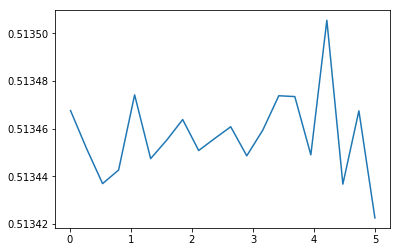

In [253]:
plt.plot(np.linspace(0.01, 5, 20), scores)

In [254]:
print('Лучший параметр регуляризации C = {}'.format(best_c))
print('Наилучшее качество score = {}'.format(best_score))

Лучший параметр регуляризации C = 4.212105263157895
Наилучшее качество score = 0.5135055599717224


### 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).